<a href="https://colab.research.google.com/github/dd1vya/Edge-AI-Defect-Classification/blob/main/claude_edge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Import essential libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import zipfile
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Upload dataset.zip from your local machine
from google.colab import files
print("Please upload your dataset.zip file:")
uploaded = files.upload()

# Extract the dataset
zip_file = list(uploaded.keys())[0]
with zipfile.ZipFile(zip_file, 'r') as zip_ref:
    zip_ref.extractall('/content/')

print("\n✓ Dataset extracted successfully!")
print("TensorFlow version:", tf.__version__)
print("GPU Available:", tf.config.list_physical_devices('GPU'))

# Verify dataset structure
print("\nDataset structure:")
for root, dirs, files in os.walk('/content/dataset'):
    level = root.replace('/content/dataset', '').count(os.sep)
    indent = ' ' * 2 * level
    print(f'{indent}{os.path.basename(root)}/')
    if level < 2:  # Only show first 2 levels
        sub_indent = ' ' * 2 * (level + 1)
        for file in files[:3]:  # Show first 3 files in each folder
            print(f'{sub_indent}{file}')
        if len(files) > 3:
            print(f'{sub_indent}... and {len(files)-3} more files')

Please upload your dataset.zip file:


Saving dataset.zip to dataset.zip

✓ Dataset extracted successfully!
TensorFlow version: 2.19.0
GPU Available: []

Dataset structure:
dataset/
  val/
    scratch/
    clean/
    other/
    particle/
    open/
    via/
    crack/
    bridge/
  train/
    scratch/
    clean/
    other/
    particle/
    open/
    via/
    crack/
    bridge/
  test/
    scratch/
    clean/
    other/
    particle/
    open/
    via/
    crack/
    bridge/


DATASET DISTRIBUTION

Class        Train      Val        Test       Total     
------------------------------------------------------------
clean        44         44         44         132       
other        1          1          1          3         
via          2          2          2          6         
particle     5          5          5          15        
open         2          2          2          6         
scratch      15         15         15         45        
crack        5          5          5          15        
bridge       5          5          5          15        
------------------------------------------------------------
TOTAL        79         79         79         237       


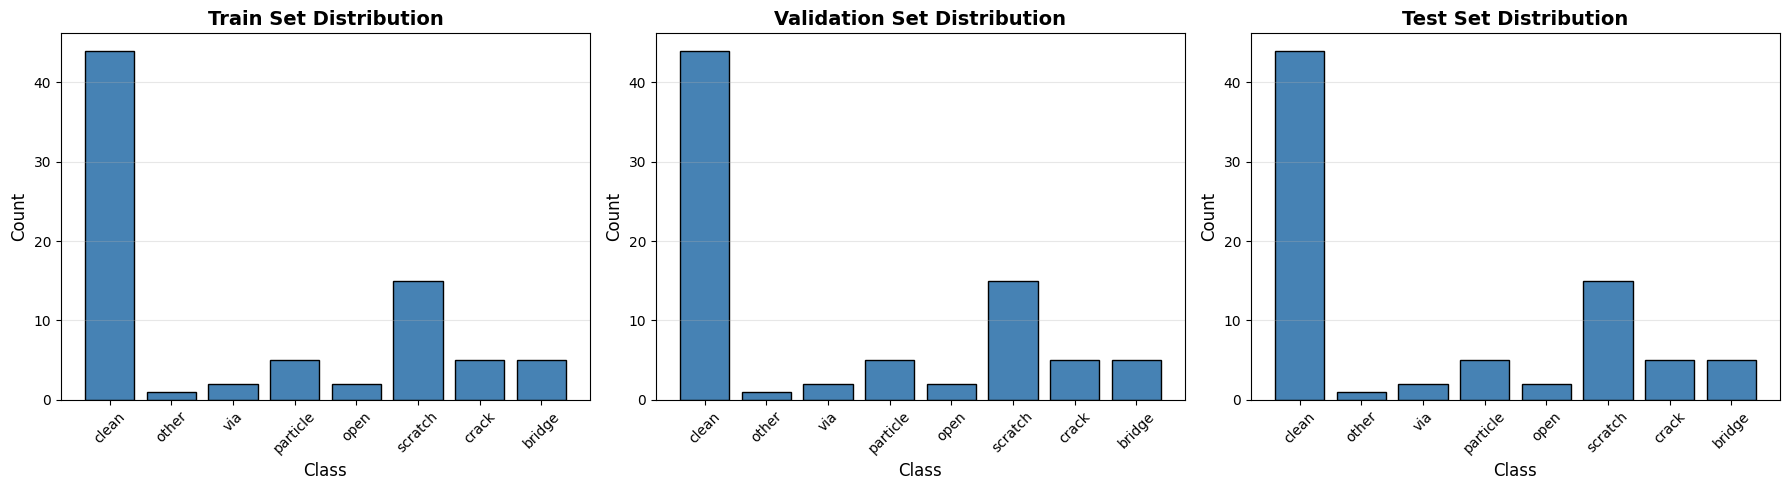


Sample Images from Training Set:


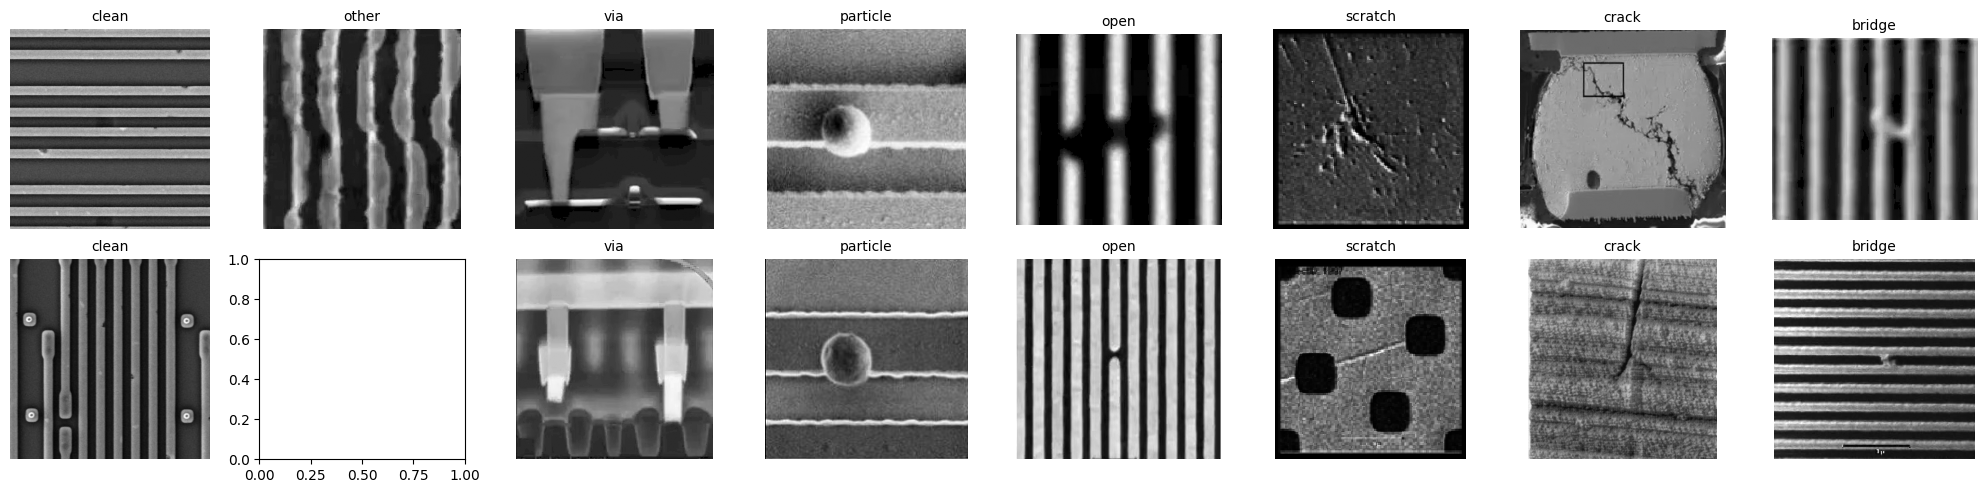

In [2]:
# Define dataset paths and class names
BASE_DIR = '/content/dataset'
TRAIN_DIR = os.path.join(BASE_DIR, 'train')
VAL_DIR = os.path.join(BASE_DIR, 'val')
TEST_DIR = os.path.join(BASE_DIR, 'test')

CLASS_NAMES = ['clean', 'other', 'via', 'particle', 'open', 'scratch', 'crack', 'bridge']
IMG_SIZE = (128, 128)  # Start with 128x128, can adjust based on performance
BATCH_SIZE = 32

# Function to count images per class
def count_images(directory):
    counts = {}
    total = 0
    for class_name in CLASS_NAMES:
        class_path = os.path.join(directory, class_name)
        if os.path.exists(class_path):
            count = len([f for f in os.listdir(class_path) if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp'))])
            counts[class_name] = count
            total += count
        else:
            counts[class_name] = 0
    return counts, total

# Count images in each split
train_counts, train_total = count_images(TRAIN_DIR)
val_counts, val_total = count_images(VAL_DIR)
test_counts, test_total = count_images(TEST_DIR)

# Display distribution
print("=" * 60)
print("DATASET DISTRIBUTION")
print("=" * 60)
print(f"\n{'Class':<12} {'Train':<10} {'Val':<10} {'Test':<10} {'Total':<10}")
print("-" * 60)
for class_name in CLASS_NAMES:
    total_class = train_counts[class_name] + val_counts[class_name] + test_counts[class_name]
    print(f"{class_name:<12} {train_counts[class_name]:<10} {val_counts[class_name]:<10} {test_counts[class_name]:<10} {total_class:<10}")
print("-" * 60)
print(f"{'TOTAL':<12} {train_total:<10} {val_total:<10} {test_total:<10} {train_total+val_total+test_total:<10}")
print("=" * 60)

# Visualize distribution
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
datasets = [('Train', train_counts), ('Validation', val_counts), ('Test', test_counts)]

for idx, (name, counts) in enumerate(datasets):
    axes[idx].bar(CLASS_NAMES, counts.values(), color='steelblue', edgecolor='black')
    axes[idx].set_title(f'{name} Set Distribution', fontsize=14, fontweight='bold')
    axes[idx].set_xlabel('Class', fontsize=12)
    axes[idx].set_ylabel('Count', fontsize=12)
    axes[idx].tick_params(axis='x', rotation=45)
    axes[idx].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# Sample visualization - show 2 images from each class
print("\nSample Images from Training Set:")
fig, axes = plt.subplots(2, 8, figsize=(20, 5))
for idx, class_name in enumerate(CLASS_NAMES):
    class_path = os.path.join(TRAIN_DIR, class_name)
    images = [f for f in os.listdir(class_path) if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp'))][:2]

    for i, img_name in enumerate(images):
        img_path = os.path.join(class_path, img_name)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        axes[i, idx].imshow(img, cmap='gray')
        axes[i, idx].set_title(class_name, fontsize=10)
        axes[i, idx].axis('off')

plt.tight_layout()
plt.show()

Found 79 images belonging to 8 classes.
Found 79 images belonging to 8 classes.
Found 79 images belonging to 8 classes.

✓ Data generators created successfully!
Training samples: 79
Validation samples: 79
Test samples: 79

Class indices: {'bridge': 0, 'clean': 1, 'crack': 2, 'open': 3, 'other': 4, 'particle': 5, 'scratch': 6, 'via': 7}

Augmented Training Samples Preview:


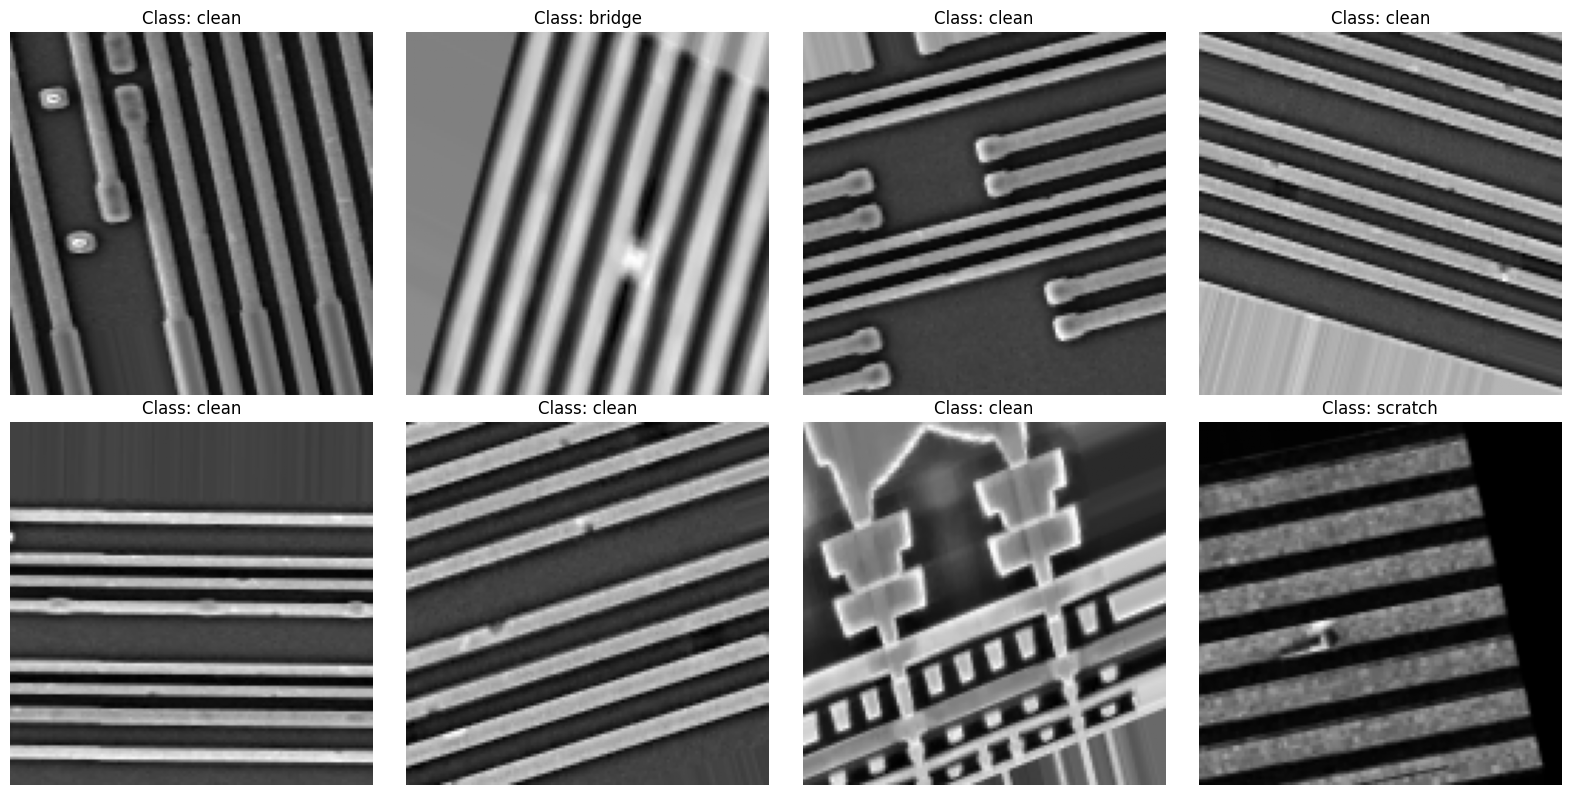

In [3]:
# Data Augmentation & Preprocessing
# More aggressive augmentation since dataset is small

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

# Only rescaling for validation and test (no augmentation)
val_test_datagen = ImageDataGenerator(rescale=1./255)

# Create data generators
train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    color_mode='grayscale',
    class_mode='categorical',
    shuffle=True,
    seed=42
)

val_generator = val_test_datagen.flow_from_directory(
    VAL_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    color_mode='grayscale',
    class_mode='categorical',
    shuffle=False,
    seed=42
)

test_generator = val_test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    color_mode='grayscale',
    class_mode='categorical',
    shuffle=False,
    seed=42
)

print("\n✓ Data generators created successfully!")
print(f"Training samples: {train_generator.samples}")
print(f"Validation samples: {val_generator.samples}")
print(f"Test samples: {test_generator.samples}")
print(f"\nClass indices: {train_generator.class_indices}")

# Visualize augmented samples
print("\nAugmented Training Samples Preview:")
sample_batch, sample_labels = next(train_generator)

fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.ravel()

for i in range(8):
    axes[i].imshow(sample_batch[i].squeeze(), cmap='gray')
    class_idx = np.argmax(sample_labels[i])
    class_name = list(train_generator.class_indices.keys())[class_idx]
    axes[i].set_title(f'Class: {class_name}', fontsize=12)
    axes[i].axis('off')

plt.tight_layout()
plt.show()

MODEL ARCHITECTURE


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 128, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │         2,056 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 276,744 (1.06 MB)

 Trainable params: 276,040 (1.05 MB)

 Non-trainable params: 704 (2.75 KB)


Estimated Model Size: 1.06 MB
Total Parameters: 276,744


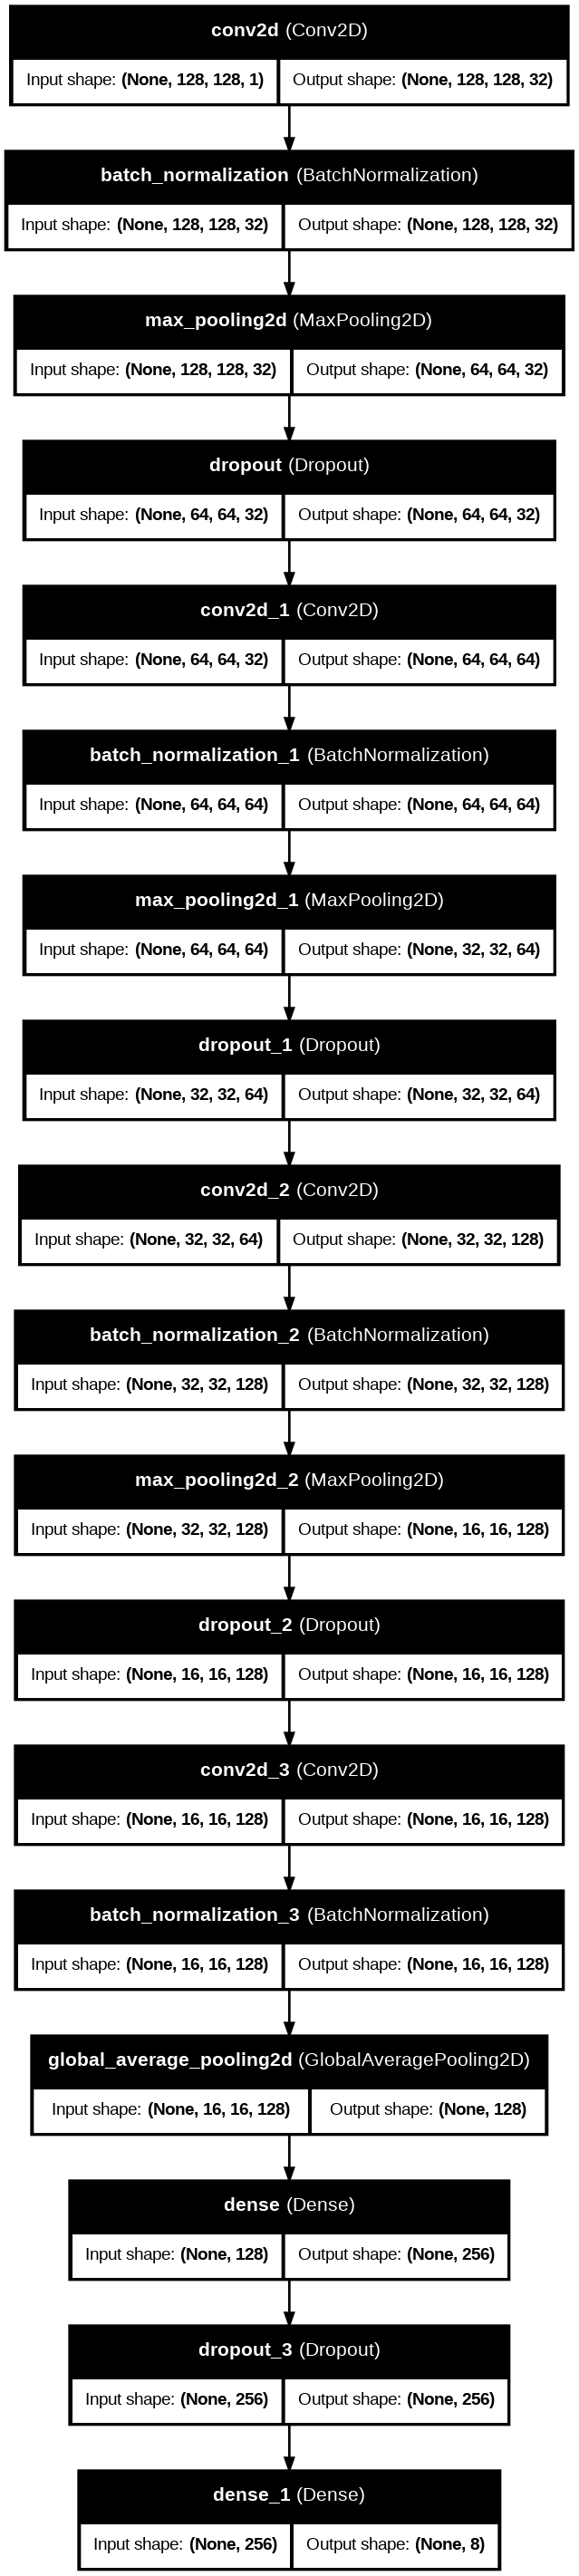

In [4]:
# Build Lightweight CNN Model for Edge Deployment
def create_edge_cnn_model(input_shape=(128, 128, 1), num_classes=8):
    """
    Lightweight CNN optimized for edge deployment
    Target: <5MB model size, high accuracy
    """
    model = models.Sequential([
        # Block 1
        layers.Input(shape=input_shape),
        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),

        # Block 2
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),

        # Block 3
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.3),

        # Block 4
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.GlobalAveragePooling2D(),  # Better than Flatten for smaller model

        # Classifier
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])

    return model

# Create model
model = create_edge_cnn_model(input_shape=(IMG_SIZE[0], IMG_SIZE[1], 1), num_classes=len(CLASS_NAMES))

# Compile model
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy', keras.metrics.Precision(), keras.metrics.Recall()]
)

# Model summary
print("=" * 70)
print("MODEL ARCHITECTURE")
print("=" * 70)
model.summary()

# Calculate model size
def get_model_size_mb(model):
    """Estimate model size in MB"""
    total_params = model.count_params()
    # Assuming float32 (4 bytes per parameter)
    size_mb = (total_params * 4) / (1024 ** 2)
    return size_mb

model_size = get_model_size_mb(model)
print(f"\n{'='*70}")
print(f"Estimated Model Size: {model_size:.2f} MB")
print(f"Total Parameters: {model.count_params():,}")
print(f"{'='*70}")

# Visualize model architecture
keras.utils.plot_model(
    model,
    to_file='model_architecture.png',
    show_shapes=True,
    show_layer_names=True,
    rankdir='TB',
    dpi=96
)

from IPython.display import Image
display(Image('model_architecture.png'))

STARTING TRAINING
Epochs: 100
Batch Size: 32
Image Size: (128, 128)
Classes: 8
Epoch 1/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3196 - loss: 1.9462 - precision: 0.3333 - recall: 0.0169        
Epoch 1: val_accuracy improved from -inf to 0.55696, saving model to /content/checkpoints/best_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 13s 3s/step - accuracy: 0.3663 - loss: 1.8997 - precision: 0.5000 - recall: 0.0253 - val_accuracy: 0.5570 - val_loss: 2.0523 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0010
Epoch 2/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7767 - loss: 1.1893 - precision: 0.9770 - recall: 0.2648
Epoch 2: val_accuracy did not improve from 0.55696
3/3 ━━━━━━━━━━━━━━━━━━━━ 7s 3s/step - accuracy: 0.7629 - loss: 1.1863 - precision: 0.9655 - recall: 0.2840 - val_accuracy: 0.5570 - val_loss: 1.9682 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0010
Epoch 3/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6679 - loss: 1.0900 - precision: 0.9018 - recall: 0.5340
Epoch 3: val_accuracy did not improve from 0.55696
3/3 ━━━━━━━━━━━━━━━━━━━━ 7s 3s/step - accuracy: 0.6876 - loss: 1.0528 - precision: 0.9019 - recall: 0.5461 - val_accuracy: 0.5570 - val_loss: 1.8718 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - lea

3/3 ━━━━━━━━━━━━━━━━━━━━ 8s 3s/step - accuracy: 0.8625 - loss: 0.4635 - precision: 0.9625 - recall: 0.7289 - val_accuracy: 0.5696 - val_loss: 1.7843 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0010
Epoch 11/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8524 - loss: 0.4225 - precision: 0.9535 - recall: 0.7529
Epoch 11: val_accuracy did not improve from 0.56962
3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 3s/step - accuracy: 0.8545 - loss: 0.4259 - precision: 0.9495 - recall: 0.7546 - val_accuracy: 0.0633 - val_loss: 1.8624 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0010
Epoch 12/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8221 - loss: 0.4574 - precision: 0.9421 - recall: 0.7844
Epoch 12: val_accuracy did not improve from 0.56962

Epoch 12: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
3/3 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - accuracy: 0.8191 - loss: 0.4640 - precision: 0.9410 - recall: 0.7782 - val_accuracy: 0.0

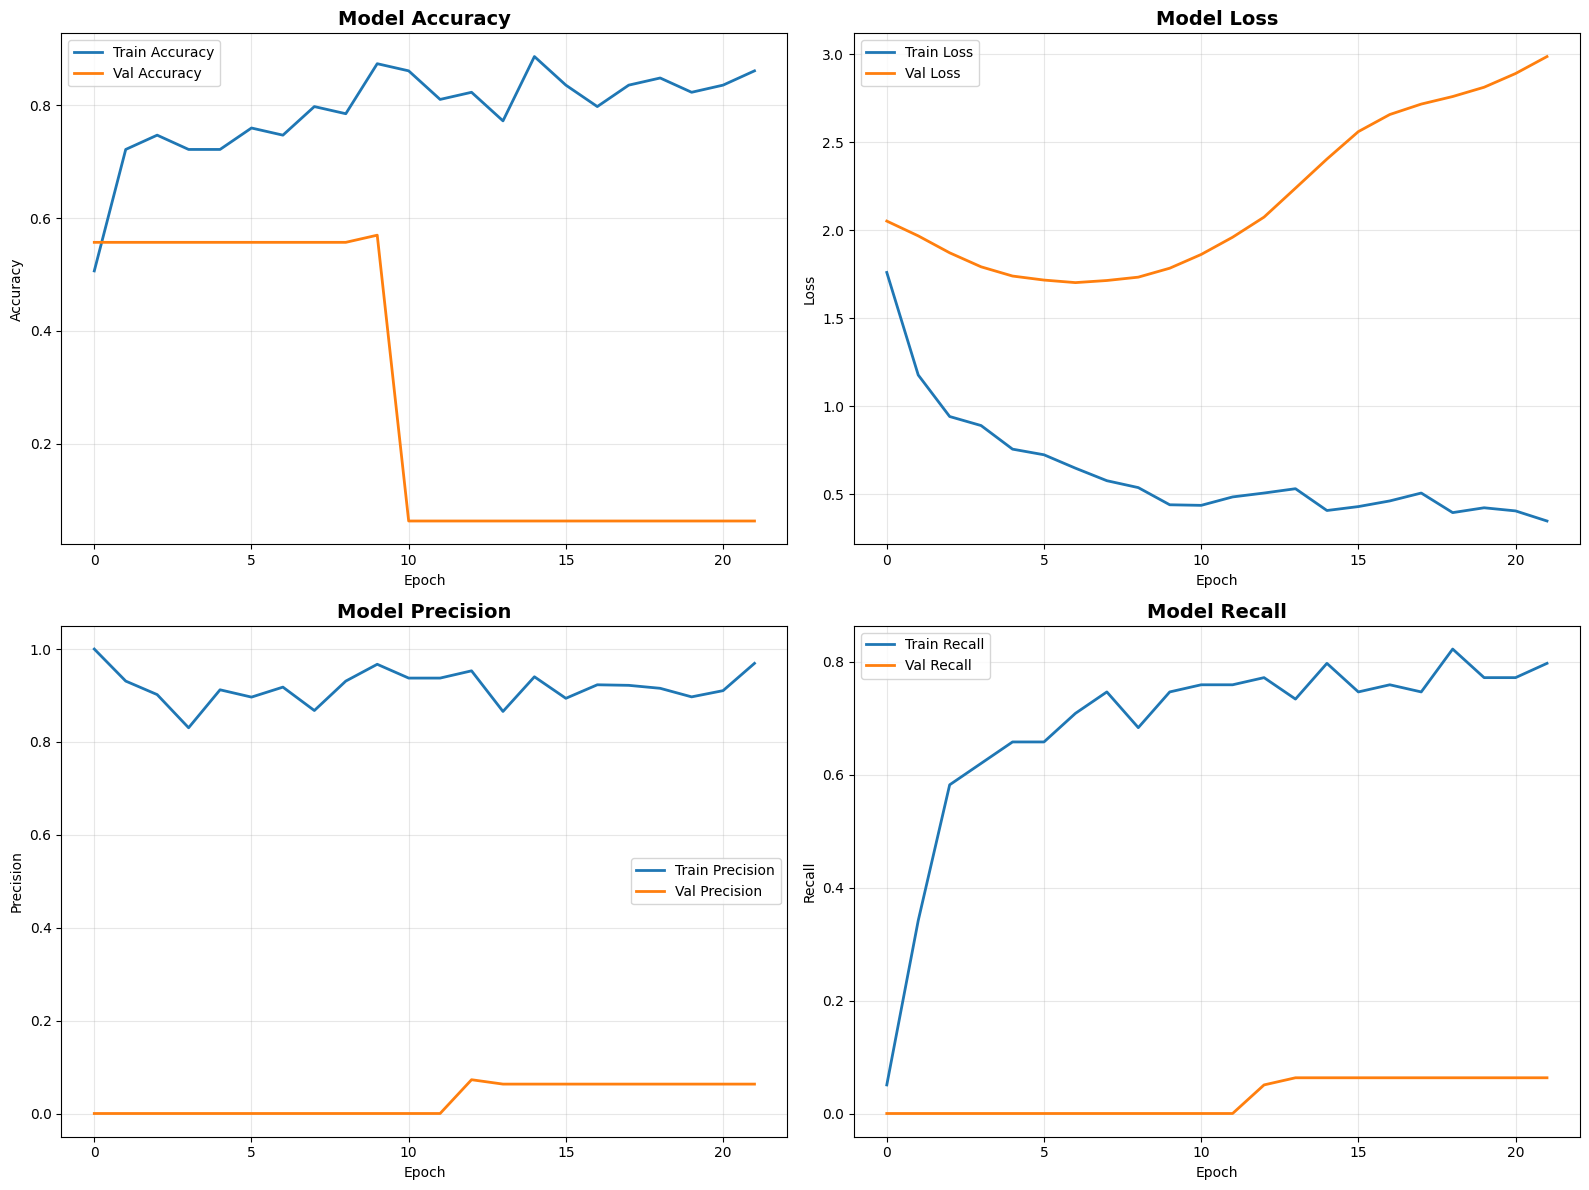


Best Validation Accuracy: 0.5696
Best Validation Loss: 1.7024


In [5]:
# Training Configuration with Callbacks

# Create checkpoint directory
os.makedirs('/content/checkpoints', exist_ok=True)

# Define callbacks
callbacks = [
    # Save best model
    keras.callbacks.ModelCheckpoint(
        '/content/checkpoints/best_model.h5',
        monitor='val_accuracy',
        save_best_only=True,
        mode='max',
        verbose=1
    ),

    # Reduce learning rate when validation loss plateaus
    keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-7,
        verbose=1
    ),

    # Early stopping to prevent overfitting
    keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=15,
        restore_best_weights=True,
        verbose=1
    ),

    # TensorBoard for visualization
    keras.callbacks.TensorBoard(
        log_dir='/content/logs',
        histogram_freq=1
    )
]

# Training parameters
EPOCHS = 100  # Will stop early if no improvement

print("=" * 70)
print("STARTING TRAINING")
print("=" * 70)
print(f"Epochs: {EPOCHS}")
print(f"Batch Size: {BATCH_SIZE}")
print(f"Image Size: {IMG_SIZE}")
print(f"Classes: {len(CLASS_NAMES)}")
print("=" * 70)

# Train the model
history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=val_generator,
    callbacks=callbacks,
    verbose=1
)

print("\n" + "=" * 70)
print("✓ TRAINING COMPLETED!")
print("=" * 70)

# Plot training history
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Accuracy
axes[0, 0].plot(history.history['accuracy'], label='Train Accuracy', linewidth=2)
axes[0, 0].plot(history.history['val_accuracy'], label='Val Accuracy', linewidth=2)
axes[0, 0].set_title('Model Accuracy', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Accuracy')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# Loss
axes[0, 1].plot(history.history['loss'], label='Train Loss', linewidth=2)
axes[0, 1].plot(history.history['val_loss'], label='Val Loss', linewidth=2)
axes[0, 1].set_title('Model Loss', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Loss')
axes[0, 1].legend()
axes[0, 1].grid(alpha=0.3)

# Precision
axes[1, 0].plot(history.history['precision'], label='Train Precision', linewidth=2)
axes[1, 0].plot(history.history['val_precision'], label='Val Precision', linewidth=2)
axes[1, 0].set_title('Model Precision', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Precision')
axes[1, 0].legend()
axes[1, 0].grid(alpha=0.3)

# Recall
axes[1, 1].plot(history.history['recall'], label='Train Recall', linewidth=2)
axes[1, 1].plot(history.history['val_recall'], label='Val Recall', linewidth=2)
axes[1, 1].set_title('Model Recall', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Recall')
axes[1, 1].legend()
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('/content/training_history.png', dpi=150, bbox_inches='tight')
plt.show()

# Print final metrics
print(f"\nBest Validation Accuracy: {max(history.history['val_accuracy']):.4f}")
print(f"Best Validation Loss: {min(history.history['val_loss']):.4f}")

EVALUATING ON TEST SET
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.6637 - loss: 1.6249 - precision: 0.0000e+00 - recall: 0.0000e+00

Test Accuracy:  0.5696 (56.96%)
Test Loss:      1.7843
Test Precision: 0.0000
Test Recall:    0.0000
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 843ms/step


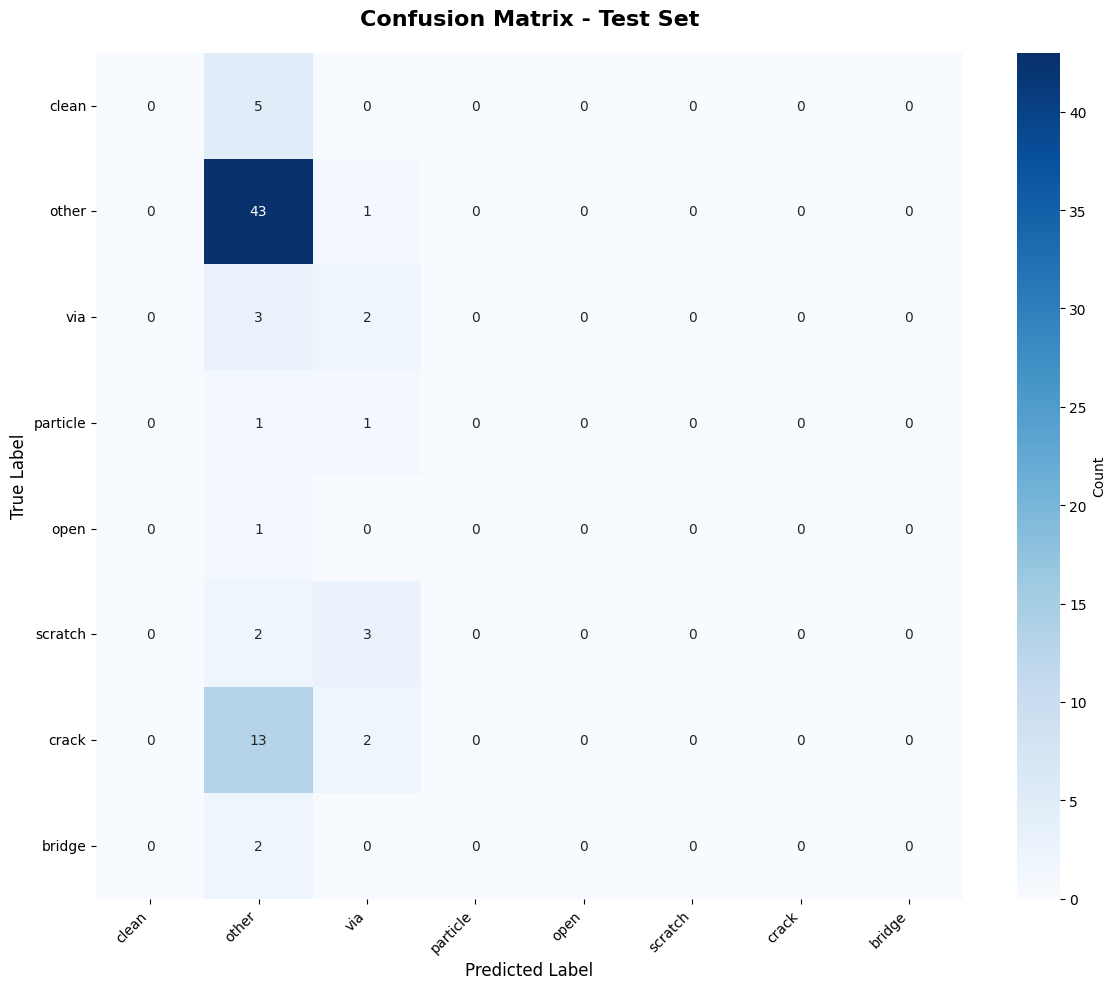


PER-CLASS PERFORMANCE
              precision    recall  f1-score   support

       clean     0.0000    0.0000    0.0000         5
       other     0.6143    0.9773    0.7544        44
         via     0.2222    0.4000    0.2857         5
    particle     0.0000    0.0000    0.0000         2
        open     0.0000    0.0000    0.0000         1
     scratch     0.0000    0.0000    0.0000         5
       crack     0.0000    0.0000    0.0000        15
      bridge     0.0000    0.0000    0.0000         2

    accuracy                         0.5696        79
   macro avg     0.1046    0.1722    0.1300        79
weighted avg     0.3562    0.5696    0.4382        79


SAMPLE MISCLASSIFICATIONS
Total misclassified: 34 out of 79


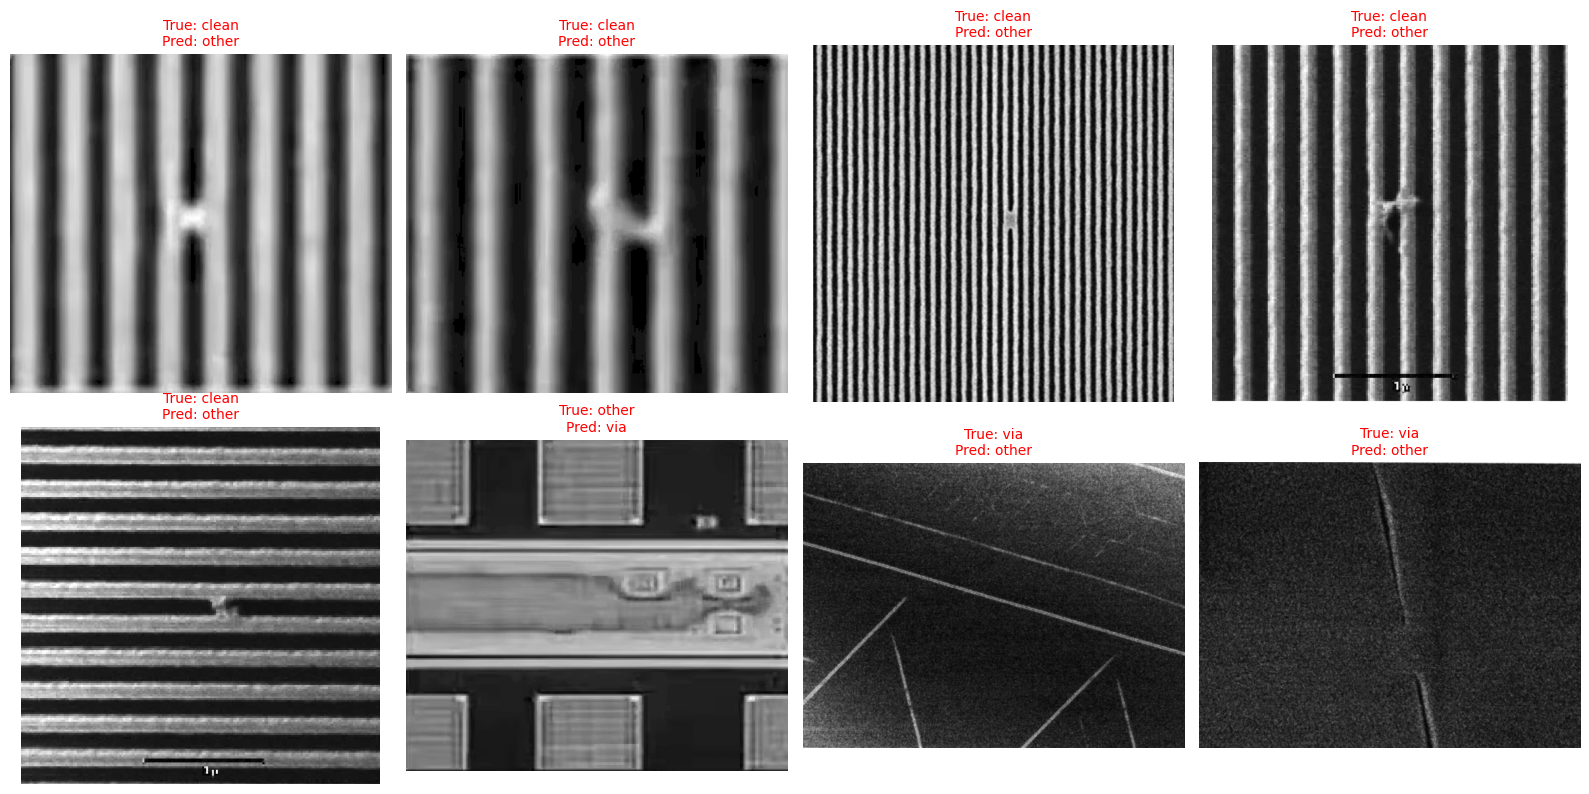

In [6]:
# Detailed Evaluation on Test Set
print("=" * 70)
print("EVALUATING ON TEST SET")
print("=" * 70)

# Load best model
model.load_weights('/content/checkpoints/best_model.h5')

# Evaluate
test_loss, test_acc, test_prec, test_rec = model.evaluate(test_generator, verbose=1)

print(f"\n{'='*70}")
print(f"Test Accuracy:  {test_acc:.4f} ({test_acc*100:.2f}%)")
print(f"Test Loss:      {test_loss:.4f}")
print(f"Test Precision: {test_prec:.4f}")
print(f"Test Recall:    {test_rec:.4f}")
print(f"{'='*70}")

# Get predictions
test_generator.reset()
y_pred_probs = model.predict(test_generator, verbose=1)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = test_generator.classes

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES,
            cbar_kws={'label': 'Count'})
plt.title('Confusion Matrix - Test Set', fontsize=16, fontweight='bold', pad=20)
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('/content/confusion_matrix.png', dpi=150, bbox_inches='tight')
plt.show()

# Per-class metrics
print("\n" + "=" * 70)
print("PER-CLASS PERFORMANCE")
print("=" * 70)
report = classification_report(y_true, y_pred, target_names=CLASS_NAMES, digits=4)
print(report)

# Show misclassified examples
print("\n" + "=" * 70)
print("SAMPLE MISCLASSIFICATIONS")
print("=" * 70)

misclassified_idx = np.where(y_pred != y_true)[0]
if len(misclassified_idx) > 0:
    print(f"Total misclassified: {len(misclassified_idx)} out of {len(y_true)}")

    # Show first 8 misclassifications
    num_show = min(8, len(misclassified_idx))
    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    axes = axes.ravel()

    for i in range(num_show):
        idx = misclassified_idx[i]
        img_path = test_generator.filepaths[idx]
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

        axes[i].imshow(img, cmap='gray')
        axes[i].set_title(f'True: {CLASS_NAMES[y_true[idx]]}\nPred: {CLASS_NAMES[y_pred[idx]]}',
                         fontsize=10, color='red')
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()
else:
    print("No misclassifications! Perfect score! 🎉")

In [7]:
# Export Model to ONNX Format

import tf2onnx
import onnx

print("=" * 70)
print("EXPORTING MODEL TO ONNX FORMAT")
print("=" * 70)

# Load best model
model.load_weights('/content/checkpoints/best_model.h5')

# Convert to ONNX
onnx_model_path = '/content/defect_classifier_model.onnx'

# Method 1: Direct conversion from Keras model
spec = (tf.TensorSpec((None, 128, 128, 1), tf.float32, name="input"),)

model_proto, _ = tf2onnx.convert.from_keras(
    model,
    input_signature=spec,
    opset=13,  # ONNX opset version (13 is widely supported)
    output_path=onnx_model_path
)

print(f"\n✓ Model exported to: {onnx_model_path}")

# Verify ONNX model
onnx_model = onnx.load(onnx_model_path)
onnx.checker.check_model(onnx_model)
print("✓ ONNX model verification passed!")

# Get ONNX model details
print("\n" + "=" * 70)
print("ONNX MODEL DETAILS")
print("=" * 70)
print(f"ONNX Version: {onnx_model.opset_import[0].version}")
print(f"Producer: {onnx_model.producer_name}")
print(f"Graph Inputs: {len(onnx_model.graph.input)}")
print(f"Graph Outputs: {len(onnx_model.graph.output)}")

# Input details
for inp in onnx_model.graph.input:
    print(f"\nInput Name: {inp.name}")
    shape = [dim.dim_value if dim.dim_value > 0 else 'dynamic' for dim in inp.type.tensor_type.shape.dim]
    print(f"Input Shape: {shape}")
    print(f"Input Type: {inp.type.tensor_type.elem_type}")

# Output details
for out in onnx_model.graph.output:
    print(f"\nOutput Name: {out.name}")
    shape = [dim.dim_value if dim.dim_value > 0 else 'dynamic' for dim in out.type.tensor_type.shape.dim]
    print(f"Output Shape: {shape}")

# Get ONNX file size
import os
onnx_size_mb = os.path.getsize(onnx_model_path) / (1024 * 1024)
print(f"\nONNX Model Size: {onnx_size_mb:.2f} MB")
print("=" * 70)

# Test ONNX model inference (optional verification)
print("\n" + "=" * 70)
print("TESTING ONNX MODEL INFERENCE")
print("=" * 70)

import onnxruntime as ort

# Create ONNX Runtime session
ort_session = ort.InferenceSession(onnx_model_path)

# Get a test sample
test_generator.reset()
test_images, test_labels = next(test_generator)
test_sample = test_images[0:1]  # Take first image

# Run inference with TensorFlow model
tf_prediction = model.predict(test_sample, verbose=0)

# Run inference with ONNX model
onnx_input = {ort_session.get_inputs()[0].name: test_sample}
onnx_prediction = ort_session.run(None, onnx_input)[0]

# Compare predictions
print(f"\nTensorFlow prediction: {np.argmax(tf_prediction[0])} ({CLASS_NAMES[np.argmax(tf_prediction[0])]})")
print(f"ONNX prediction: {np.argmax(onnx_prediction[0])} ({CLASS_NAMES[np.argmax(onnx_prediction[0])]})")
print(f"Predictions match: {np.argmax(tf_prediction[0]) == np.argmax(onnx_prediction[0])}")

# Check numerical difference
max_diff = np.max(np.abs(tf_prediction - onnx_prediction))
print(f"Max numerical difference: {max_diff:.8f}")

if max_diff < 1e-5:
    print("✓ ONNX conversion is accurate!")
else:
    print("⚠ Small numerical differences detected (normal for conversion)")

print("\n" + "=" * 70)
print("✓ ONNX EXPORT COMPLETE!")
print("=" * 70)
print(f"\nYour ONNX model is ready at: {onnx_model_path}")
print("You can download it for submission!")

ModuleNotFoundError: No module named 'tf2onnx'